In [1]:
!wget https://raw.githubusercontent.com/medianeuroscience/emfd/refs/heads/master/dictionaries/mfd2.0.dic

--2025-12-01 22:31:06--  https://raw.githubusercontent.com/medianeuroscience/emfd/refs/heads/master/dictionaries/mfd2.0.dic
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24574 (24K) [text/plain]
Saving to: ‘mfd2.0.dic.1’

mfd2.0.dic.1        100%[===================>]  24.00K  --.-KB/s    in 0.003s  

2025-12-01 22:31:06 (7.67 MB/s) - ‘mfd2.0.dic.1’ saved [24574/24574]



In [2]:
from typing import List
import pandas as pd
MFD2 = 'mfd2.0.dic'
nummap = dict()
mfd2 = dict()
wordmode = True
with open(MFD2, 'r') as f:
    for line in f.readlines():
        ent = line.strip().split()
        if line[0] == '%':
            wordmode = not wordmode
        elif len(ent) > 0:
            if wordmode:
                #print(ent)
                moral = nummap[ent[-1]]
                if (moral not in mfd2.keys()):
                    mfd2[moral] = []
                mfd2[moral].append(''.join([e for e in ent if e not in nummap.keys()]))

            # mfd2[]].append(ent[0])
            # elif ent[0] in nummap.keys():
            #     wordkey = ''.join([e for e in ent if e not in nummap.keys()])
            #     mfd2[wordkey] = [nummap[e] for e in ent if e in nummap.keys()]
            else:
                nummap[ent[0]] = ent[1]

# mfd2 = pd.DataFrame.from_dict(mfd2).T
# mfd2['foundation'] = mfd2[0]
# del mfd2[0]
# mfd2 = mfd2.T.to_dict()

In [3]:
mfd2.keys()
# nummap

dict_keys(['care.virtue', 'care.vice', 'fairness.virtue', 'fairness.vice', 'loyalty.virtue', 'loyalty.vice', 'authority.virtue', 'authority.vice', 'sanctity.virtue', 'sanctity.vice'])

In [4]:
foundations = ['care','fairness','loyalty','authority','sanctity']

In [5]:
!pip install sentence-transformers


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [6]:
from sentence_transformers import SentenceTransformer
EMBEDDINGS_MODEL_NAME='l3cube-pune/indic-sentence-similarity-sbert'
model = SentenceTransformer(EMBEDDINGS_MODEL_NAME)

/Users/devisivakumar/MyWorkspace/ANLP_Project/anlp-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate word embeddings

**Reasoning**:
Iterate through the mfd2 dictionary and generate embeddings for each word in each moral foundation category using the loaded S-BERT model. Store the embeddings in the word_embeddings dictionary.


In [7]:
word_embeddings = {}
for foundation, words in mfd2.items():
  word_embeddings[foundation] = model.encode(words)

## [English] Master moral vectors

For each moral foundation, calculate the average of the word embeddings to create a single "Master Moral Vector".

Iterate through the word_embeddings dictionary and calculate the mean of the word embeddings for each moral foundation to create the Master Moral Vectors.


In [8]:
import numpy as np

master_moral_vectors = {}
for foundation, embeddings in word_embeddings.items():
    master_moral_vectors[foundation] = np.mean(embeddings, axis=0)

print("Master Moral Vectors:")
for foundation, vector in master_moral_vectors.items():
    print(f"{foundation}: {vector[:5]}...") # Print first 5 elements for brevity

Master Moral Vectors:
care.virtue: [-0.01993794  0.01070593 -0.00855213 -0.00665717 -0.00125954]...
care.vice: [-0.01250592  0.00353126  0.01182757  0.00208265 -0.00288362]...
fairness.virtue: [-0.01801289  0.00632953 -0.0019798  -0.01034678  0.00363413]...
fairness.vice: [-0.00022982  0.00463817  0.02136709 -0.00873424 -0.00330092]...
loyalty.virtue: [-0.01397729  0.00466763  0.00886195 -0.00529534  0.00739838]...
loyalty.vice: [-0.00110871 -0.00215744  0.01932479 -0.00913977 -0.00764371]...
authority.virtue: [-0.01551665  0.01278673  0.00741049 -0.00466473  0.00591277]...
authority.vice: [-0.00704374  0.00444568  0.02150437 -0.00651294 -0.00208919]...
sanctity.virtue: [-0.01712277  0.01087363  0.00984664 -0.00748536 -0.00979777]...
sanctity.vice: [-0.0074419   0.00531518  0.03010704 -0.00677086 -0.00364618]...


# Plot each word in the mfd2 dataset along with its corresponding "Master Moral Vector" for each moral foundation.

### Combine embeddings

Combine the individual word embeddings and the master moral vectors into a single dataset.

**Reasoning**:
Combine the word embeddings and master moral vectors into a single list with corresponding labels.


In [9]:
all_embeddings = []
embedding_labels = []

for foundation, embeddings in word_embeddings.items():
    all_embeddings.extend(embeddings)
    embedding_labels.extend([f'{foundation} - word'] * len(embeddings))

for foundation, vector in master_moral_vectors.items():
    all_embeddings.append(vector)
    embedding_labels.append(f'{foundation} - master')

print(f"Total number of embeddings: {len(all_embeddings)}")
print(f"Total number of labels: {len(embedding_labels)}")

Total number of embeddings: 2114
Total number of labels: 2114


## Dimensionality reduction

### Subtask:
Reduce the dimensionality of the combined embeddings using a technique like PCA or t-SNE.

**Reasoning**:
Reduce the dimensionality of the combined embeddings using PCA.


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

## Create dataframe

### Subtask:
Create a pandas DataFrame from the reduced embeddings, including columns for the moral foundation and whether the point is a word or a master vector.

**Reasoning**:
Create a pandas DataFrame from the reduced embeddings and add a column for the labels, then print the head of the DataFrame.


In [11]:
import pandas as pd

df_reduced = pd.DataFrame(reduced_embeddings, columns=['dim1', 'dim2'])
df_reduced['label'] = embedding_labels
print(df_reduced.head())

       dim1      dim2               label
0 -0.268612  0.144410  care.virtue - word
1 -0.336714  0.063559  care.virtue - word
2 -0.303893  0.136507  care.virtue - word
3 -0.260672  0.156821  care.virtue - word
4 -0.054319  0.207595  care.virtue - word


## Visualize embeddings

### Subtask:
Plot the reduced embeddings using a scatter plot, using different colors for each moral foundation and different markers for words and master vectors.

**Reasoning**:
Create a scatter plot of the reduced embeddings, coloring by label and using different markers for words and master vectors.


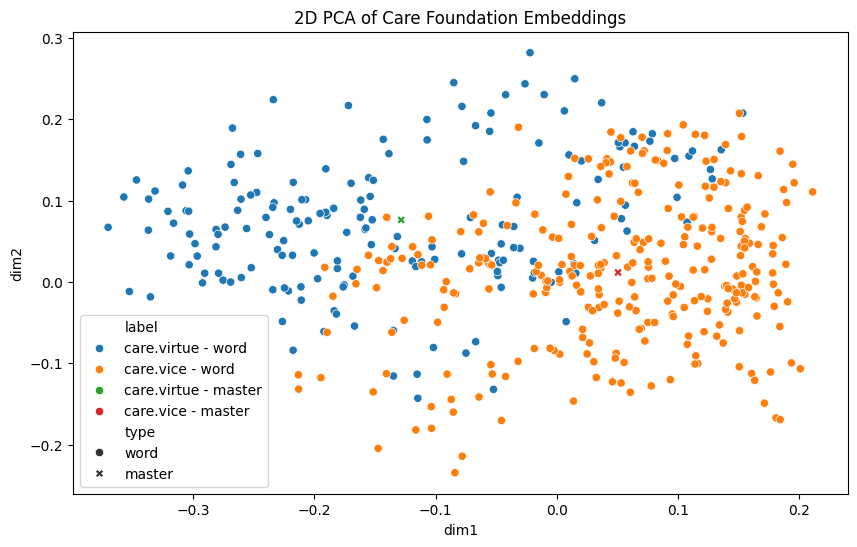

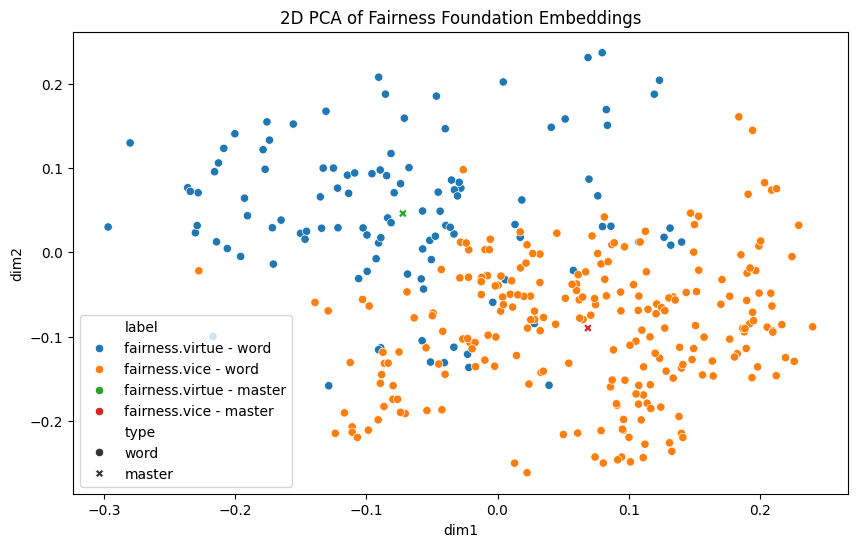

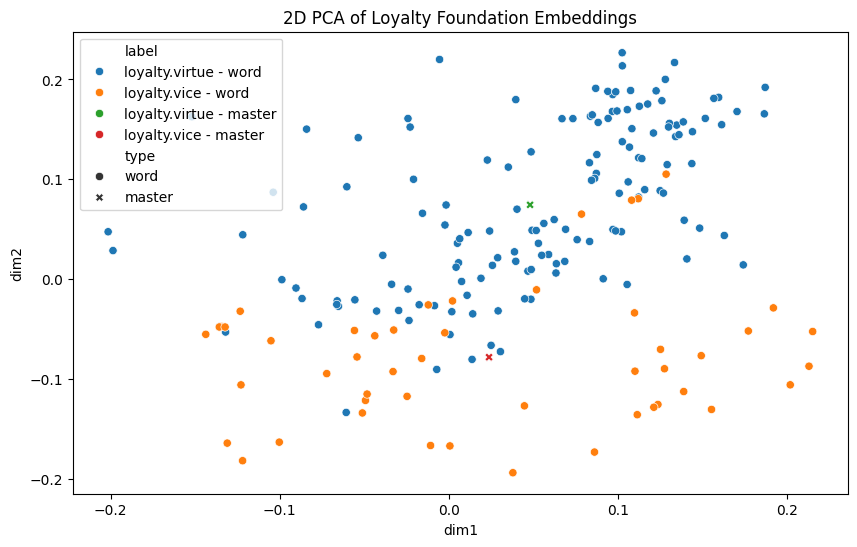

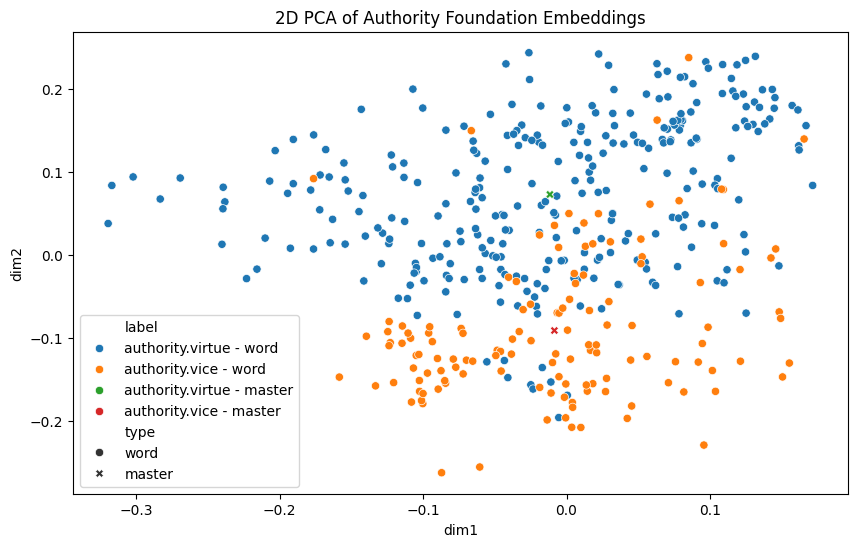

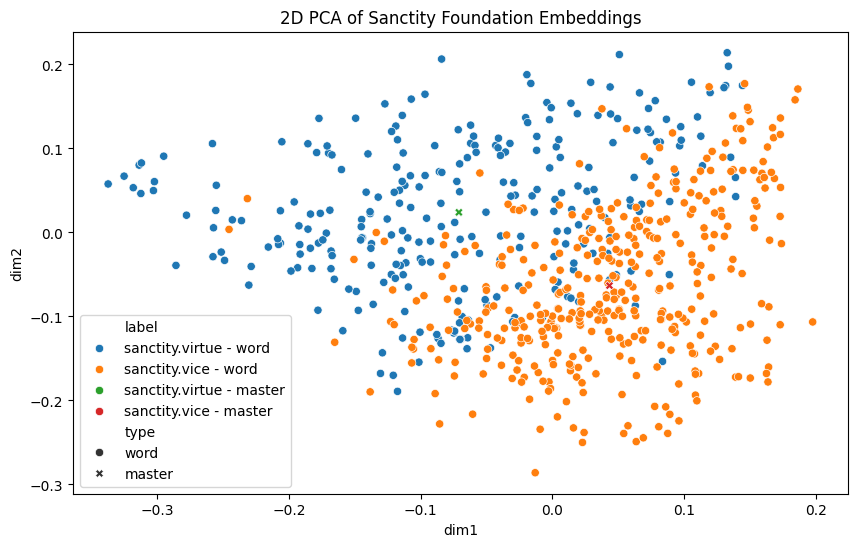

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df_reduced['type'] = df_reduced['label'].apply(lambda x: 'master' if 'master' in x else 'word')

# Get the unique moral foundations
foundations = df_reduced['label'].apply(lambda x: x.split('.')[0]).unique()

for foundation in foundations:
    plt.figure(figsize=(10, 6))
    foundation_df = df_reduced[df_reduced['label'].str.startswith(foundation)]
    sns.scatterplot(data=foundation_df, x='dim1', y='dim2', hue='label', style='type')
    plt.title(f'2D PCA of {foundation.capitalize()} Foundation Embeddings')
    plt.show()

In [ ]:
# Authenticate with Hugging Face using token
# Get your token from: https://huggingface.co/settings/tokens
from huggingface_hub import login

# Replace 'YOUR_HF_TOKEN_HERE' with your actual Hugging Face token
HF_TOKEN = "YOUR_HF_TOKEN_HERE"
login(token=HF_TOKEN)

## Option 2: Translate MFD to Tamil (First Time Only)

**Only run these cells if you don't have `tamil_mfd.pkl` yet!**  
This requires GPU and takes a long time. After running, download the generated `tamil_mfd.pkl` file.

## Option 1: Load Pre-translated Dictionary (Recommended)

If you already have `tamil_mfd.pkl` from a previous run, **run this cell** and **skip the translation cells below**.

In [ ]:
## Workflow Summary

**First time (with GPU):**
1. Run the translation cell above to generate `translated_dictionary_tamil`
2. Run the save cell above to create `tamil_mfd.pkl`
3. Download `tamil_mfd.pkl` from Colab/Jupyter (Files → Right-click → Download)
4. Commit it to git for future use

**Every subsequent time:**
1. Upload `tamil_mfd.pkl` to your environment
2. Run the "Load Pre-translated Dictionary" cell above
3. Skip the translation cells entirely
4. Continue with the embeddings section below

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

def translate_dict_to_tamil(input_dict: dict) -> dict:
    """
    Translates the string values in a dictionary of lists to Tamil.

    Args:
        input_dict: A dictionary where keys are strings and values are lists of strings.
                    Example: {'moral': ['word1', 'word2'], 'moral2': ['word3']}

    Returns:
        A new dictionary with the same keys but with translated string values.
    """
    # Define the model name and target language
    model_name = "sarvamai/sarvam-translate"
    tgt_lang = "Tamil"

    # Auto-detect device (GPU if available, otherwise CPU)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

    translated_dict = {}
    # Iterate over each key-value pair in the input dictionary
    for key, words in input_dict.items():
        translated_words = []
        # Iterate over each word in the list
        for word in words:
            # Create the prompt for the model using a chat template
            messages = [
                {"role": "system", "content": f"Translate the text below to {tgt_lang}."},
                {"role": "user", "content": word}
            ]

            # Apply the chat template to structure the conversation
            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )

            # Tokenize the input and move it to the model's device (GPU)
            model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

            # Generate the translation
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=128,  # Increased token limit for potentially longer words
                do_sample=True,
                temperature=0.01,
                num_return_sequences=1
            )

            # Decode the generated output to get the translated text
            output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()
            output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
            translated_words.append(output_text.strip())

        # Assign the list of translated words to the corresponding key
        translated_dict[key] = translated_words

    return translated_dict

# --- Example Usage ---


# 2. Call the function to get the translated dictionary
#    (This requires a machine with a compatible GPU and transformers installed)
translated_dictionary_tamil = translate_dict_to_tamil(mfd2)

# 3. Print the result
print(translated_dictionary_tamil)


In [ ]:
# Save the translated dictionary to avoid re-running translation every time
import pickle

with open('tamil_mfd.pkl', 'wb') as f:
    pickle.dump(translated_dictionary_tamil, f)

print("✓ Saved translated_dictionary_tamil to tamil_mfd.pkl")
print("  Download this file and upload it next time to skip translation!")

## [TODO]: Save this dict locally or to git, and pull it from there. Shouldn't run every time.

## [Tamil] Embeddings

In [ ]:
word_embeddings_tamil = {}
for foundation, words in translated_dictionary_tamil.items():
  word_embeddings_tamil[foundation] = model.encode(words)


## [Tamil] Master Moral Vectors

In [ ]:
import numpy as np

master_moral_vectors_tamil = {}
for foundation, embeddings in word_embeddings_tamil.items():
    master_moral_vectors_tamil[foundation] = np.mean(embeddings, axis=0)

print("Master Moral Vectors:")
for foundation, vector in master_moral_vectors_tamil.items():
    print(f"{foundation}: {vector[:5]}...") # Print first 5 elements for brevity

# Task
Create a Tamil moral foundations dictionary file (`tamil_mfd.dic`). This file should contain a '% word %' section with each translated Tamil word from `translated_dictionary_tamil` mapped to its corresponding numerical code, and a '% category %' section mapping these numerical codes back to their original moral foundation names. Finally, confirm the successful creation of this file.

## Create Foundation to Number Mapping

### Subtask:
Generate a reverse mapping from moral foundation names (e.g., 'care.virtue') to their numerical codes (e.g., '1') using the existing `nummap` dictionary. This mapping is essential for structuring the new `.dic` file.

**Reasoning**:
To generate the reverse mapping from moral foundation names to their numerical codes, I will iterate through the existing `nummap` dictionary and swap the keys and values to populate the `foundation_to_num` dictionary as instructed.


In [ ]:
foundation_to_num = {}
for num_code, foundation_name in nummap.items():
    foundation_to_num[foundation_name] = num_code

print("Foundation to Number Mapping:")
print(foundation_to_num)

**Reasoning**:
Now that the reverse mapping from moral foundation names to numerical codes is established, the next step is to create the `tamil_mfd.dic` file. This involves writing the category mapping and then the translated Tamil words with their corresponding numerical codes into the file.


In [ ]:
output_filename = 'tamil_mfd.dic'

with open(output_filename, 'w', encoding='utf-8') as f:
    f.write('% category %\n')
    # Write the numerical code to foundation name mapping
    for num_code, foundation_name in nummap.items():
        f.write(f'{num_code}\t{foundation_name}\n')

    f.write('% word %\n')
    # Write the translated Tamil words mapped to their numerical codes
    for foundation_name, tamil_words in translated_dictionary_tamil.items():
        num_code = foundation_to_num.get(foundation_name)
        if num_code:
            for word in tamil_words:
                f.write(f'{word}\t{num_code}\n')

print(f"Successfully created '{output_filename}' with Tamil MFD data.")

## Final Task

### Subtask:
Confirm that the `tamil_mfd.dic` file has been created successfully and provide guidance on how to integrate this file into your workflow or version control system.

## Summary:

### Q&A
The `tamil_mfd.dic` file has been created successfully. To integrate this file into your workflow, you can typically place it in a designated directory where your linguistic analysis software expects dictionary files. For version control, you should add `tamil_mfd.dic` to your repository using `git add tamil_mfd.dic` and then commit it (`git commit -m "Add tamil_mfd.dic"`). This ensures the dictionary is tracked and available for collaborative work and future use.

### Data Analysis Key Findings
*   A `foundation_to_num` dictionary was successfully created, mapping moral foundation names (e.g., 'care.virtue') to their numerical codes (e.g., '1'), which is crucial for structuring the dictionary file.
*   An initial attempt to create the `tamil_mfd.dic` file encountered a `SyntaxError: unterminated string literal`, specifically because newline characters (`\n`) were missing from the section header string literals (e.g., `'% category %'`).
*   The syntax error was resolved by correcting the string literals to include newlines (e.g., `f.write('% category %\n')`).
*   The `tamil_mfd.dic` file was then successfully created, containing a `'% category %'` section that maps numerical codes to moral foundation names and a `'% word %'` section that maps translated Tamil words to their corresponding numerical codes.

### Insights or Next Steps
*   Ensure that file writing operations, especially for structured text files, correctly handle line endings and string literal terminations to prevent common syntax errors.
*   The generated dictionary file is ready for use in computational linguistics tasks requiring moral foundation analysis for Tamil text, enabling further research or application development.